# Recomendaciones proyecto


1. **Rendimiento esperado:**  
   - No es necesario alcanzar un rendimiento cercano al **100%** para obtener la nota máxima en el proyecto. Se evaluará la calidad del enfoque, la justificación de las decisiones tomadas y la interpretación de los resultados obtenidos.  

2. **Uso de muestras en caso de limitaciones:**  
   - Si su equipo no puede cargar o procesar todos los datos debido a limitaciones de recursos (como RAM), puede trabajar con **muestras representativas del conjunto de datos**.  
   - Es **obligatorio justificar** este enfoque en el informe, explicando claramente las razones detrás de la decisión y cómo se asegura que las muestras son representativas.  

3. **Optimización de recursos:**  
   - Si enfrenta problemas de memoria al ejecutar tareas, **reduzca la cantidad de procesos paralelos** (**jobs**) a un nivel que su computador o intérprete web pueda manejar. Es preferible priorizar la estabilidad del proceso sobre la velocidad.

4. **Paralelización para búsquedas de hiperparámetros:**  
   - Aproveche la paralelización para acelerar la búsqueda de hiperparámetros, especialmente si esta es un cuello de botella en su proyecto. Herramientas como `GridSearchCV`, `RandomizedSearchCV` o `Optuna` suelen permitir paralelización configurando el parámetro `n_jobs`.  

5. **Grillas de búsqueda razonables:**  
   - Al realizar búsquedas de hiperparámetros, **diseñe grillas de búsqueda razonables** que no sean excesivamente grandes.  
   - Recuerde que, aunque explorar un mayor espacio de hiperparámetros puede parecer atractivo, también puede hacer que el proceso sea extremadamente lento o inviable. Ajuste el tamaño de las grillas para garantizar que la búsqueda **converja en tiempos razonables** y no tome **"3.5 eternidades"**.



A continuación, se detallan las tareas que deben completar para la **Entrega Parcial 1**. Recuerden que el principal entregable es **predecir, con su mejor modelo, sobre los clientes del archivo `X_t1.parquet` y subir las predicciones a la plataforma CodaLab**. **Para esta entrega el desarrollo del informe es sugerido, pero no mandatorio**. Asegúrense de utilizar el archivo correspondiente para subir los resultados a la competencia. El uso de datos incorrectos se reflejará en un bajo desempeño en la tabla de clasificación.

### **Tareas a realizar:**
1. **Análisis exploratorio de datos:**  
   Realicen un análisis detallado para identificar patrones, tendencias y relaciones en los datos. Este paso les permitirá comprender mejor las características del conjunto de datos y guiar las siguientes decisiones en el pipeline de modelamiento.

2. **Preprocesamiento de datos:**  
   Incluyan técnicas de preprocesamiento que aseguren la calidad y adecuación de los datos para los modelos. Algunas tareas sugeridas son:  
   - Estandarización de filas y/o columnas.  
   - Reducción de dimensionalidad.  
   - Discretización de variables numéricas a categóricas.  
   - Manejo de datos nulos.  
   - Otras transformaciones relevantes según los datos disponibles.  

3. **División del conjunto de datos:**  
   Implementen una técnica **Hold-Out**, separando el conjunto de datos en **70% para entrenamiento** y **30% para testeo**.

4. **Creación de un modelo baseline:**  
   Entrenen un modelo sencillo que sirva como línea base para comparar el rendimiento de los modelos más avanzados.

5. **Desarrollo de 3 modelos de Machine Learning diferentes al baseline:**  
   - Utilicen exclusivamente pipelines de **Scikit-Learn** para esta iteración del proyecto.  
   - El uso de librerías o herramientas externas será penalizado con una calificación de **0** en las secciones implicadas.  

6. **Interpretabilidad del modelo con mejores resultados:**  
   Apliquen técnicas que permitan interpretar y justificar los resultados obtenidos por el modelo con mejor desempeño.

----------------------------------------------

# Informe Proyecto Lab
Integrantes: 
- Alonso Uribe
- Carolina Núñez
  
Grupo: Adaval


#### **1. Introducción [0.25 puntos]**  
Esta sección debe incluir:  
- Una breve descripción del problema planteado: ¿Qué se intenta predecir?  
- Un resumen de los datos de entrada proporcionados.  
- La métrica seleccionada para evaluar los modelos, justificando su elección. Considerando que los datos están desbalanceados, eviten usar `accuracy` y enfoquen su análisis en métricas como `precision`, `recall` o `f1-score`, indicando en qué clase se centrarán.  
- Una mención breve de los modelos utilizados para resolver el problema, incluyendo las transformaciones intermedias aplicadas a los datos.  
- Un cierre con un análisis general de los resultados obtenidos, indicando si el modelo final cumplió con los objetivos y cómo se posicionaron respecto a otros equipos.

In [421]:
import datetime
import numpy as np 
import pandas as pd 
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer


maxcols = pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)

In [422]:
# para entrenar
X_t0 = pd.read_parquet('X_t0.parquet')
y_t0 = pd.read_parquet('y_t0.parquet')
# para predecir(?)
X_t1 = pd.read_parquet('X_t1.parquet')
X_t0 = X_t0[sorted(X_t0.columns)]
X_t1 = X_t1[sorted(X_t1.columns)]

# Analisis exploratorio de los datos

#### **2. Modelos con Scikit-Learn (Entrega Parcial 1)**

##### **2.1. Análisis Exploratorio de Datos [0.5 puntos]**  
Realicen un análisis que explore patrones, tendencias y relaciones clave en los datos. Incluyan:  
- Estadísticas descriptivas generales.  
- Visualizaciones para identificar distribuciones, valores atípicos y posibles relaciones entre variables.  
- Cualquier observación relevante que pueda influir en las etapas posteriores del proyecto.  

El informe debe ser detallado y profesional, demostrando no solo la implementación técnica, sino también una comprensión profunda de los datos y la problemática planteada.



In [423]:
pd.set_option("display.max_columns", maxcols )
X_t0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   avg_gas_paid_per_tx_eth                  44296 non-null  float64
 1   avg_risk_factor                          44296 non-null  float64
 2   avg_weighted_risk_factor                 44296 non-null  float64
 3   borrow_amount_avg_eth                    44296 non-null  float64
 4   borrow_amount_sum_eth                    44296 non-null  float64
 5   borrow_block_number                      44296 non-null  int64  
 6   borrow_count                             44296 non-null  int64  
 7   borrow_repay_diff_eth                    44296 non-null  float64
 8   borrow_timestamp                         44296 non-null  float64
 9   deposit_amount_sum_eth                   44296 non-null  float64
 10  deposit_count                            44296

In [424]:
# Verificamos que no hayan valores nulos
X_t0.isnull().sum()

avg_gas_paid_per_tx_eth                  0
avg_risk_factor                          0
avg_weighted_risk_factor                 0
borrow_amount_avg_eth                    0
borrow_amount_sum_eth                    0
                                        ..
unique_lending_protocol_count            0
wallet_address                           0
wallet_age                               0
withdraw_amount_sum_eth                  0
withdraw_deposit_diff_if_positive_eth    0
Length: 77, dtype: int64

In [425]:
numeric_var = X_t0.select_dtypes(include=['number']).columns
object_var = X_t0.select_dtypes(include=['object']).columns
timestamps = pd.Index([col for col in X_t0.columns if "timestamp" in col])
numeric_var = numeric_var.drop(timestamps)
timestamps = timestamps.drop('risky_first_last_tx_timestamp_diff')
ts_diff_col = pd.Index(['risky_first_last_tx_timestamp_diff'])

Observamos que las columnas timestamp hablan de fechas de transacción. Sin conocimiento del negocio, hablan de una fecha inicio y termino del prestamo(?)

In [426]:
(X_t0[ts_diff_col[0]] == (X_t0['risky_last_tx_timestamp']) - X_t0['risky_first_tx_timestamp']).sum()/ len(X_t0)

np.float64(1.0)

Aquí podemos ver que la columna `risky_first_last_tx_timestamp_diff` corresponde a la diferencia entre las columnas `risky_last_tx_timestamp` y `risky_first_tx_timestamp`.  
Por lo tanto debemos decidir que necesitamos del fenómeno, los valores absolutos en el tiempo, o solo la diferencia de estos valores. Concluimos que estos tres valores junto no entraran al modelo.

Con la variable `borrow_timestamp` podemos hacer una cuenta simple de las veces que cada cliente pidio un prestamo y agregar esta variable al dataset, descartando este campo.

In [427]:
# borrow_times : numero de prestamos por cliente 
def borrow_times_col(df):
    vars = object_var.insert(len(object_var), 'borrow_timestamp')
    borrow_per_cli = df[vars].groupby(*object_var).count().rename(columns={'borrow_timestamp':'borrow_times'})
    borrow_per_cli = borrow_per_cli.reset_index()
    df = df.merge(borrow_per_cli, on='wallet_address')
    return df
    
borrow_times_col_transformer = FunctionTransformer(borrow_times_col)

In [428]:
# Busca las variables binarias a partir del número de valores distintos que tenga
from feature_engine.selection import DropConstantFeatures
weird = defaultdict(list)
threshold = 0.5

for col in X_t0[numeric_var]:
    diff_values = len(X_t0[col].value_counts())
    min_prop = (X_t0[col] == X_t0[col].min()).sum() / len(X_t0[col]) 
    max_prop = (X_t0[col] == X_t0[col].max()).sum() / len(X_t0[col])
    is_binary = diff_values == 2
    is_weird = False
    if min_prop > threshold and not is_binary :
        weird['min_prop'].append(col)
    if max_prop > threshold and not is_binary :
        weird['max_prop'].append(col)
    if is_binary:
        weird['binary'].append(col)
    print(f"{col}:\n # valores distintos: {diff_values}\n Proporción de valor mínimo: {min_prop}\n Proporción de valor máximo: {max_prop};\n\n")

avg_gas_paid_per_tx_eth:
 # valores distintos: 44247
 Proporción de valor mínimo: 0.000428932635000903
 Proporción de valor máximo: 2.257540184215279e-05;


avg_risk_factor:
 # valores distintos: 33887
 Proporción de valor mínimo: 0.1553639154776955
 Proporción de valor máximo: 2.257540184215279e-05;


avg_weighted_risk_factor:
 # valores distintos: 33815
 Proporción de valor mínimo: 0.2322557341520679
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_amount_avg_eth:
 # valores distintos: 35723
 Proporción de valor mínimo: 0.16005959906086328
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_amount_sum_eth:
 # valores distintos: 34824
 Proporción de valor mínimo: 0.16005959906086328
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_block_number:
 # valores distintos: 42584
 Proporción de valor mínimo: 2.257540184215279e-05
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_count:
 # valores distintos: 2466
 Proporción de valor mínimo: 0.153241

In [429]:
num_cli = len(X_t0[object_var].value_counts())
print("Numero total de clientes en el registro:", num_cli)

Numero total de clientes en el registro: 6788


In [430]:
transformer = DropConstantFeatures(tol=threshold)
transformer.fit_transform(X_t0[numeric_var])
cuasiconstant = transformer.features_to_drop_
cuasiconstant

['liquidation_amount_sum_eth',
 'liquidation_count',
 'market_ht_trendmode',
 'risk_factor_above_threshold_daily_count',
 'risky_sum_outgoing_amount_eth',
 'risky_tx_count',
 'risky_unique_contract_count',
 'time_since_last_liquidated',
 'unique_borrow_protocol_count',
 'unique_lending_protocol_count',
 'withdraw_deposit_diff_if_positive_eth']

In [431]:
for name, keys in weird.items():
    print(f"{name.upper()}:\n {', '.join(sorted(keys))}\n")

MIN_PROP:
 liquidation_amount_sum_eth, liquidation_count, risk_factor_above_threshold_daily_count, risky_sum_outgoing_amount_eth, risky_tx_count, risky_unique_contract_count, withdraw_deposit_diff_if_positive_eth

BINARY:
 market_ht_trendmode, unique_borrow_protocol_count, unique_lending_protocol_count

MAX_PROP:
 time_since_last_liquidated



In [432]:
pd.set_option("display.max_columns", None)
X_t0[weird['max_prop']].describe()

,time_since_last_liquidated
count,4.429600e+04
mean,7.754784e+08
std,4.166387e+08
min,8.000000e+00
25%,1.000000e+09
50%,1.000000e+09
75%,1.000000e+09
max,1.000000e+09


In [433]:
X_t0[weird['min_prop']].describe()


,liquidation_amount_sum_eth,liquidation_count,risk_factor_above_threshold_daily_count,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,withdraw_deposit_diff_if_positive_eth
count,44296.000000,44296.000000,4.429600e+04,44296.000000,44296.000000,44296.000000,44296.000000
mean,2374.206031,7.432364,5.741237e+04,888.809718,1.639426,0.455075,231.373416
std,11585.656295,28.850631,3.201195e+05,10556.796626,6.430854,1.407241,4758.504180
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,9.900000e+01,0.000000,0.000000,0.000000,0.000000
max,84050.817324,184.000000,3.125567e+06,237072.330260,122.000000,58.000000,710786.012201


### Test de Anderson

Para determinar que variables se comportan de manera gaussiana, se implementará el test de D'Agostino and Pearson con nivel de significancia del 95%, cuya hipótesis nula es que los datos provienen de una distribución dada. En este caso, de una distribución normal. Entonces, si el p-value es menor al nivel de significancia se rechaza la nula, es decir, los datos no provienen de una distribución normal.

(Este test es similar al Test de Kolmogorov-Smirnov, sin embargo funciona bien para muestras grandes)

In [434]:
# D'Agostino and Pearson test
from scipy.stats import kstest, norm, anderson, normaltest

# Test de normalidad
data = X_t0[numeric_var].copy()

normal_var = []
for var in numeric_var:
    statistic, p_value = normaltest(data[var])
    # print(f'Variable: {var}\n statistic: {statistic}    p_value: {p_value}\n')
    if p_value >= 0.05 : # No se rechaza la nula -> Los datos distribuyen normal
        normal_var.append(var)

normal_var

[]

Para sorpresa nuestra, según los test realizados, ninguna de las variables numéricas distribuye normal.

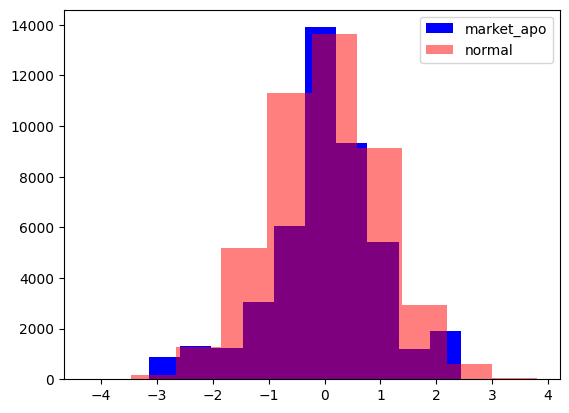

In [435]:
from numpy import random

# plt.hist(X_t0['market_apo'], color='blue', label='market_apo');
plt.hist((X_t0['market_apo']-X_t0['market_apo'].mean())/X_t0['market_apo'].std(), color='blue', label='market_apo');
plt.hist(np.random.normal(0, 1, len(X_t0['market_cmo'])), alpha=0.5, color='red', label='normal');
plt.legend()

Observamos que estas variables tienen datos atípicos para una variable numérica

# Preprocesamiento

##### **2.2 Preprocesamiento de Datos [0.25 puntos]**

Esta sección se centra en la limpieza y preparación de los datos para garantizar que sean adecuados para el entrenamiento y evaluación de los modelos. Es fundamental ejecutar un **`train_test_split`** para dividir los datos en conjuntos de entrenamiento y validación, siguiendo la proporción establecida (por ejemplo, 70/30). 

Se espera la implementación de diversas técnicas de preprocesamiento, tales como:  
- **Uso de `ColumnTransformer`:** Permite aplicar transformaciones específicas a diferentes columnas de manera eficiente.  
- **Imputación de valores nulos:** Elija una estrategia adecuada (media, mediana, moda, etc.) para completar los datos faltantes.  
- **Discretización de variables:** Convierte variables numéricas continuas en categóricas, si resulta útil para el modelo.  
- **Estandarización o normalización:** Mejora el rendimiento de algunos algoritmos que son sensibles a la escala de los datos.  
- Otras transformaciones necesarias dependiendo de las características específicas del conjunto de datos.

El proceso debe estar bien documentado y justificado en el informe, explicando las decisiones tomadas en función de los datos y los objetivos del proyecto.



In [436]:
numeric_var = numeric_var.drop(weird['binary'])
to_datetime_transformer = FunctionTransformer(lambda df: df.map(lambda ms: datetime.datetime.fromtimestamp(ms)))

In [437]:
first_transformer = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_var),
    ('categoric', MinMaxScaler(), weird['binary'] + ['borrow_times'])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False)

first_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 Index(['avg_gas_paid_per_tx_eth', 'avg_risk_factor',
       'avg_weighted_risk_factor', 'borrow_amount_avg_eth',
       'borrow_amount_sum_eth', 'borrow_block_number', 'borrow_count',
       'borrow_repay_diff_eth', 'deposit_amount_sum_eth', 'deposit_count',
       'incoming_tx_avg_eth', 'incoming_tx_cou...
       'total_available_borrows_eth', 'total_balance_eth',
       'total_collateral_avg_eth', 'total_collateral_eth',
       'total_gas_paid_eth', 'wallet_age', 'withdraw_amount_sum_eth',
       'withdraw_deposit_diff_if_positive_eth'],
      dtype='object')),
                                ('categoric', MinMaxScaler(),
                                 ['market_ht_trendmode',
                                  'unique_borrow_protocol_count',
                                  'unique_lending_protocol_count',
                                  'borrow_times'])],
                  verbose_feature_names_out=False)

In [ ]:
def ts_diff(df:pd.DataFrame):
    df['ts_diff_tx'] = df['last_tx_timestamp'] - df['first_tx_timestamp']
    df = df.rename(columns={'risky_first_last_tx_timestamp_diff':'ts_diff_risky_tx'})
    # df.drop(columns=['last_tx_timestamp', 'first_tx_timestamp'], inplace=True)
    return df

def ts_diff_tosec(df:pd.DataFrame):
    for col in df:
        if col.startswith("ts_diff"):
            df[col] = df[col] / 1000
    return df

# timestamps = timestamps.drop(["last_tx_timestamp", "first_tx_timestamp"])
ts_diff_transformer = FunctionTransformer(ts_diff) 
ts_diff_tosec_transformer = FunctionTransformer(ts_diff_tosec) 

pre_pipe = Pipeline([
    ('borrow_times_col', borrow_times_col_transformer),
    ('rescaleing', first_transformer),
    ('ts_diff', ts_diff_transformer),
    ('ts_diff_tosec', ts_diff_tosec_transformer),
    ('order', FunctionTransformer(lambda df: df[sorted(df.columns)]))])

optimus = pre_pipe.fit_transform(X_t0)
optimus

,avg_gas_paid_per_tx_eth,avg_risk_factor,avg_weighted_risk_factor,borrow_amount_avg_eth,borrow_amount_sum_eth,borrow_block_number,borrow_count,borrow_repay_diff_eth,borrow_times,borrow_timestamp,deposit_amount_sum_eth,deposit_count,incoming_tx_avg_eth,incoming_tx_count,incoming_tx_sum_eth,liquidation_amount_sum_eth,liquidation_count,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastd,market_fastk,market_ht_trendmode,market_linearreg_slope,market_macd,market_macd_macdext,market_macd_macdfix,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,max_eth_ever,max_risk_factor,min_eth_ever,net_incoming_tx_count,outgoing_tx_avg_eth,outgoing_tx_count,outgoing_tx_sum_eth,repay_amount_avg_eth,repay_amount_sum_eth,repay_count,risk_factor,risk_factor_above_threshold_daily_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,time_since_first_deposit,time_since_last_liquidated,total_available_borrows_avg_eth,total_available_borrows_eth,total_balance_eth,total_collateral_avg_eth,total_collateral_eth,total_gas_paid_eth,ts_diff_risky_tx,ts_diff_tx,unique_borrow_protocol_count,unique_lending_protocol_count,wallet_address,wallet_age,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth
0,-0.232649,-1.256644,-0.174730,-0.139263,-0.263437,-2.099846,-0.283573,-0.237842,0.010543,1.557197e+09,-0.257612,-0.270986,-0.128783,-0.261122,-0.279313,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346,-1.192479,1.038875,0.683379,-0.652171,0.096934,0.220307,0.967150,1.0,0.267883,0.059891,-0.248464,0.057592,-0.035233,-0.357680,-0.035270,-2.757783,-0.687659,1.195731,-0.056625,-0.329363,0.722749,0.722749,-0.165273,-1.519752,-0.043492,0.056233,-0.127205,-0.234284,-0.277434,-0.099228,-0.246179,-0.290332,-1.213694,-0.179349,999999999,999999999,-0.084194,-0.254934,-0.323385,-0.827621,0.538894,-0.174585,-0.130826,-0.058243,-0.173483,-0.142355,-0.173391,0.000,19972.815,0.0,1.0,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,-0.326625,-0.240781,-0.048624
1,-0.232440,-1.256641,-0.174730,-0.139067,-0.263431,-2.099838,-0.280540,-0.237831,0.010543,1.557197e+09,-0.257612,-0.270986,-0.128801,-0.260796,-0.279312,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346,-1.192479,1.038875,0.683379,-0.652171,0.096934,0.220307,0.967150,1.0,0.267883,0.059891,-0.248464,0.057592,-0.035233,-0.357680,-0.035270,-2.757783,-0.687659,1.195731,-0.056625,-0.329363,0.722749,0.722749,-0.165273,-1.519749,-0.043492,0.056233,-0.127225,-0.234030,-0.277434,-0.099228,-0.246179,-0.290332,-1.199911,-0.179349,999999999,999999999,-0.084194,-0.254934,-0.323385,-0.827606,0.538894,-0.160048,-0.130869,-0.058243,-0.168768,-0.142355,-0.173266,0.000,19973.049,1.0,1.0,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,-0.326620,-0.240781,-0.048624
2,-0.232184,-1.248831,-0.174730,-0.138924,-0.263417,-2.099834,-0.277506,-0.237805,0.010543,1.557197e+09,-0.257612,-0.270986,-0.128816,-0.260469,-0.279309,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346,-1.192479,1.038875,0.683379,-0.652171,0.096934,0.220307,0.967150,1.0,0.267883,0.059891,-0.248464,0.057592,-0.035233,-0.357680,-0.035270,-2.757783,-0.687659,1.195731,-0.056625,-0.329363,0.722749,0.722749,-0.165273,-1.507679,-0.043492,0.056233,-0.127245,-0.233776,-0.277434,-0.099228,-0.246179,-0.290332,-1.166098,-0.179349,999999999,999999999,-0.084194,-0.254934,-0.323385,-0.827601,0.538894,-0.160084,-0.130975,-0.058243,-0.168768,-0.142355,-0.173129,0.000,19973.188,1.0,1.0,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,-0.326619,-0.240781,-0.048624
3,0.972234,-1.256644,-0.174730,-0.139263,-0.263437,-2.099132,-0.283573,-0.237842,0.000000,1.557205e+09,-0.258531,-0.285000,-0.136557,-0.323436,-0.285785,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346

In [442]:
from feature_engine.selection import SmartCorrelatedSelection

corr_var = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.999,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

corr_var.fit_transform(optimus)
# Set de variables correlacionadas
print(f'Variables correlacionas:\n {corr_var.correlated_feature_sets_}')

# Primera variable se retiene, se escoje la variable con mayor variabilidad del grupo.
print(f'Variables que retener:\n {corr_var.correlated_feature_dict_}')

# Variables por eliminar
print(f'Variables a eliminar:\n {corr_var.features_to_drop_}')

# Se puede definir un conjunto de variables que consideramos importantes de retener si o si e integrar esto a una pipeline

Variables correlacionas:
 [{'risky_last_tx_timestamp', 'risky_first_tx_timestamp'}, {'borrow_block_number', 'borrow_timestamp'}, {'wallet_age', 'ts_diff_tx'}, {'market_rocp', 'market_rocr'}, {'market_macd_macdext', 'market_apo'}, {'market_macdsignal', 'market_macdsignal_macdfix'}, {'market_macd_macdfix', 'market_macd'}]
Variables que retener:
 {'risky_last_tx_timestamp': {'risky_first_tx_timestamp'}, 'borrow_timestamp': {'borrow_block_number'}, 'ts_diff_tx': {'wallet_age'}, 'market_rocr': {'market_rocp'}, 'market_apo': {'market_macd_macdext'}, 'market_macdsignal': {'market_macdsignal_macdfix'}, 'market_macd': {'market_macd_macdfix'}}
Variables a eliminar:
 ['risky_first_tx_timestamp', 'borrow_block_number', 'wallet_age', 'market_rocp', 'market_macd_macdext', 'market_macdsignal_macdfix', 'market_macd_macdfix']


In [443]:
for key, values in corr_var.correlated_feature_dict_.items():
    print(f"{key.upper()} feature es la con más variabilidad, correlaciona con subconjunto {[value.upper() for value in values]} de features\n") 

RISKY_LAST_TX_TIMESTAMP feature es la con más variabilidad, correlaciona con subconjunto ['RISKY_FIRST_TX_TIMESTAMP'] de features

BORROW_TIMESTAMP feature es la con más variabilidad, correlaciona con subconjunto ['BORROW_BLOCK_NUMBER'] de features

TS_DIFF_TX feature es la con más variabilidad, correlaciona con subconjunto ['WALLET_AGE'] de features

MARKET_ROCR feature es la con más variabilidad, correlaciona con subconjunto ['MARKET_ROCP'] de features

MARKET_APO feature es la con más variabilidad, correlaciona con subconjunto ['MARKET_MACD_MACDEXT'] de features

MARKET_MACDSIGNAL feature es la con más variabilidad, correlaciona con subconjunto ['MARKET_MACDSIGNAL_MACDFIX'] de features

MARKET_MACD feature es la con más variabilidad, correlaciona con subconjunto ['MARKET_MACD_MACDFIX'] de features



In [ ]:
def plot_qqplot(df, columns, num_cols=7, dist='norm'):
    columns = columns if not isinstance(columns, str) else [columns]
    num_rows = int(len(columns)/num_cols)+min(1, len(columns)%num_cols)
    fig, axes = plt.subplots(num_rows, num_cols if num_rows != 1 else len(columns), sharex=True)
    axes = axes.reshape(-1) if isinstance(axes, type(np.array([]))) else [axes]
    box_size = 2
    fig.set_figwidth(26 if num_rows > 1 else box_size*len(columns))
    fig.set_figheight(num_rows*box_size)

    for i, col in enumerate(columns):
        data, _ = stats.probplot(df[col], dist=dist, plot=axes[i])
        axes[i].set_title(col)
        if i!=0:
            axes[i].set_ylabel('')
        if isinstance(axes, type(np.array([]))) and i!=(len(axes)-1):
            axes[i].set_xlabel('')
    fig.set
    plt.show()

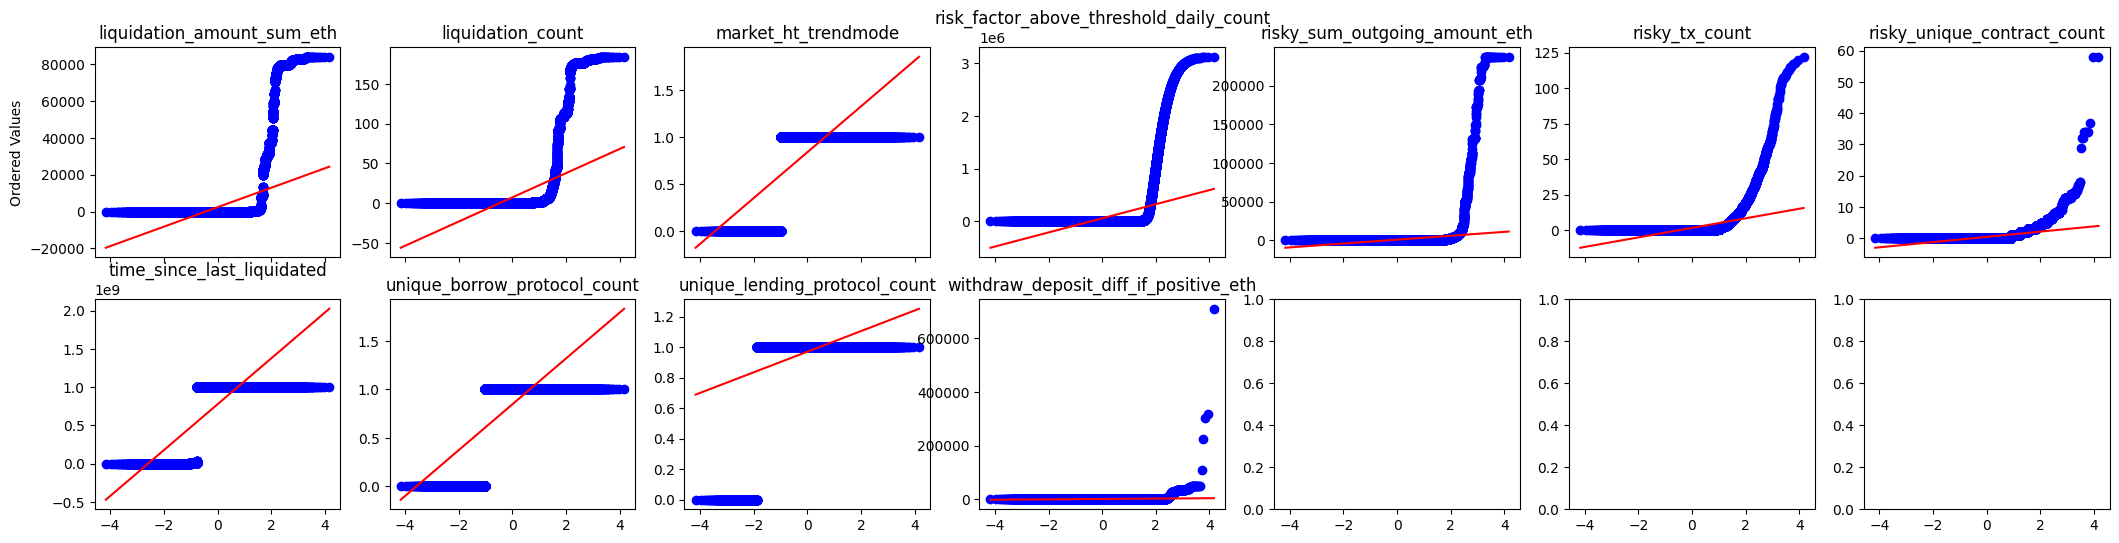

In [444]:
plot_qqplot(X_t0[X_t0.select_dtypes(include=['number']).columns], cuasiconstant)

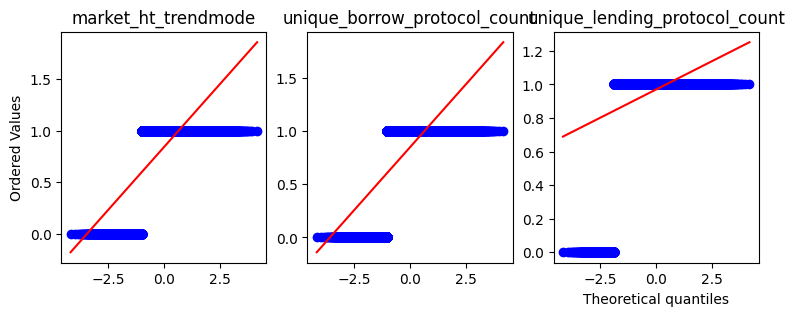

In [445]:
plot_qqplot(X_t0, weird['binary'])

qqplot esperado para varible binaria

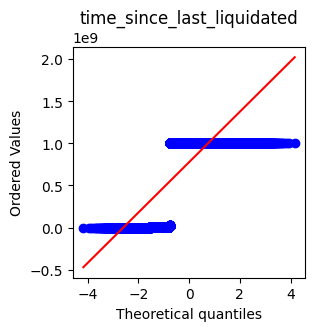

In [446]:
plot_qqplot(X_t0, weird['max_prop'])

Este campo se asumirá como variable binaria

liquidation_amount_sum_eth, liquidation_count, risk_factor_above_threshold_daily_count, risky_sum_outgoing_amount_eth, risky_tx_count, risky_unique_contract_count, withdraw_deposit_diff_if_positive_eth


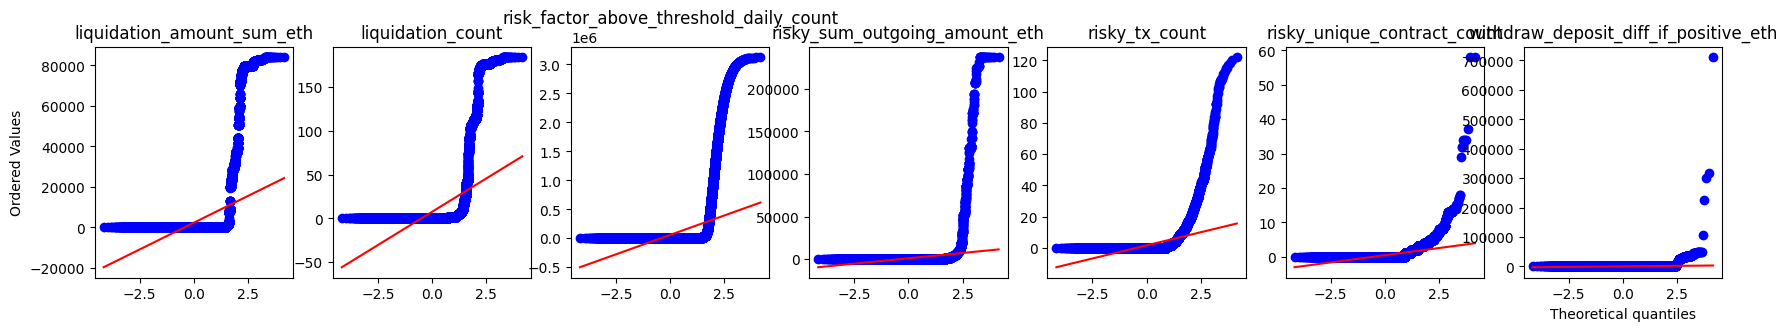

In [447]:
print(", ".join(weird['min_prop']))
plot_qqplot(X_t0, weird['min_prop'])

Podemos observar en las primeras 5 variables un comportamiento parecido a una variable binaria. Para facilitar la predicción al modelo, podemos definir para ellas 3 o 4 bins, donde los bins 2 y 3 serían valores de transición desde los menores a los mayores valores encontrados.

Para las demás variables, vemos comportamientos interesantes. Por ejemplo para `max_market_drawdown_365d` se observan valores escalonados, lo que también podría permitirnos simplificar estos valores en bins. A su vez, vemos que varias se comportan de manera normal.

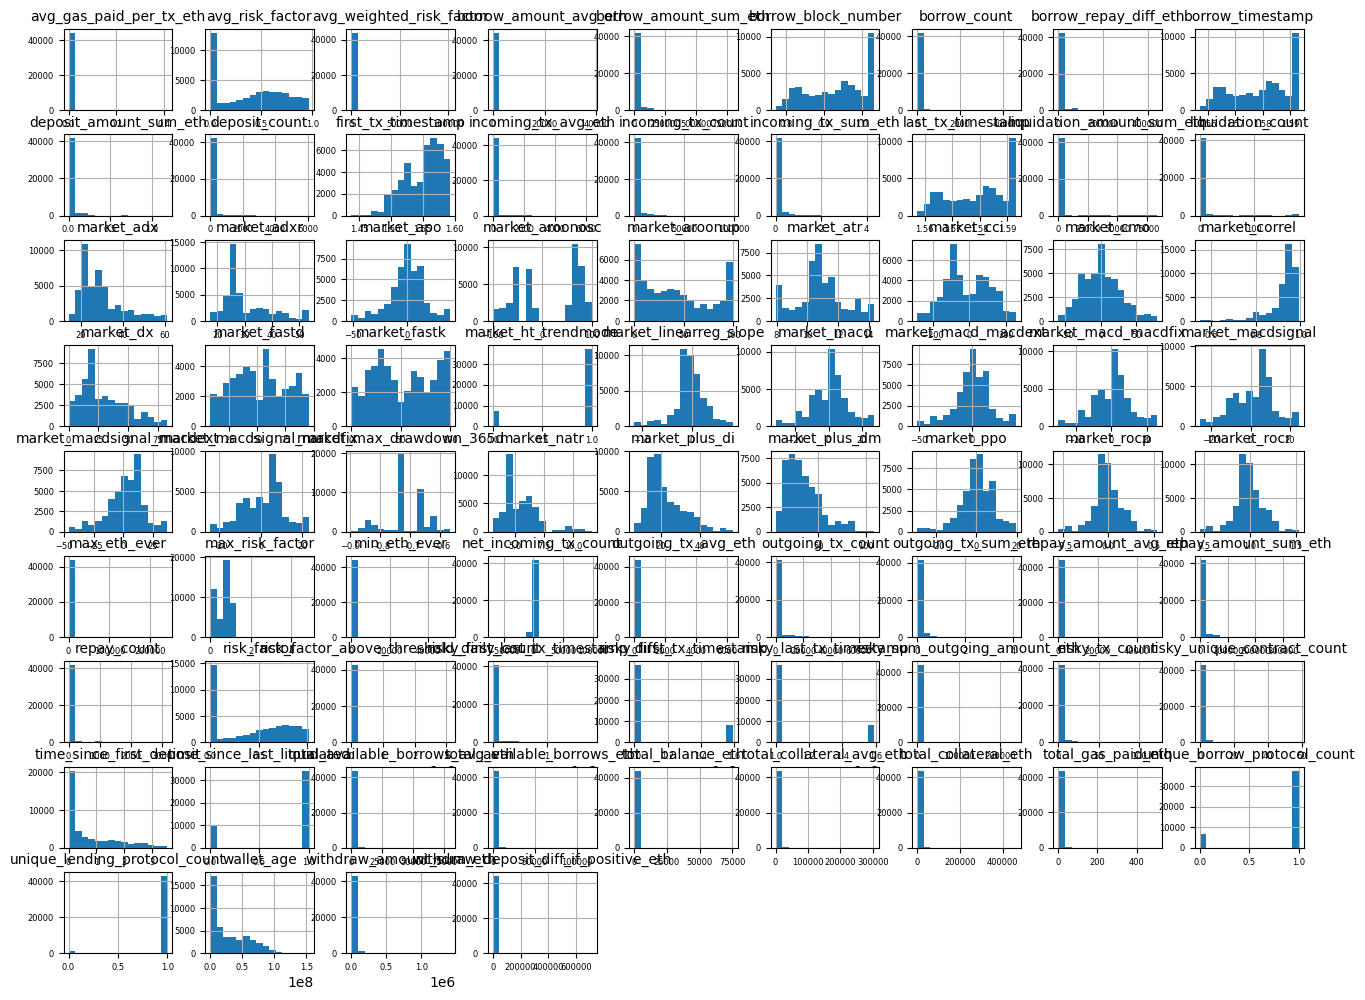

In [448]:
pd.set_option("display.max_columns", maxcols)
# Histogramas para revisar el comportamiento de las variable
axes = X_t0[X_t0.drop(columns=weird['not']).columns].hist(figsize=(16,12), bins=15)
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

In [449]:
X_corr = X_t0[numeric_var].corr().stack()
X_corr = X_corr[X_corr.index.get_level_values(0) != X_corr.index.get_level_values(1)]
X_corr > 0.95

avg_gas_paid_per_tx_eth                avg_risk_factor             False
                                       avg_weighted_risk_factor    False
                                       borrow_amount_avg_eth       False
                                       borrow_amount_sum_eth       False
                                       borrow_block_number         False
                                                                   ...  
withdraw_deposit_diff_if_positive_eth  total_collateral_avg_eth    False
                                       total_collateral_eth        False
                                       total_gas_paid_eth          False
                                       wallet_age                  False
                                       withdraw_amount_sum_eth     False
Length: 4422, dtype: bool

In [450]:
X_corr = X_t0[numeric_var].corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = X_corr.columns,
        y = X_corr.index,
        z = np.array(X_corr),
        text=X_corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(title_text='Correlación entre las variables numéricas',
                    height=800, width=1400)
fig.show()

In [451]:
y_t0.value_counts()

target
1         22656
0         21640
Name: count, dtype: int64

Vemos etiquetas balanceadas.

In [476]:
client_map = {client:i for i, client in enumerate(sorted(X_t0['wallet_address'].unique()))}
X_t0['wallet_address_id'] = X_t0['wallet_address'].apply(lambda code: client_map[code])

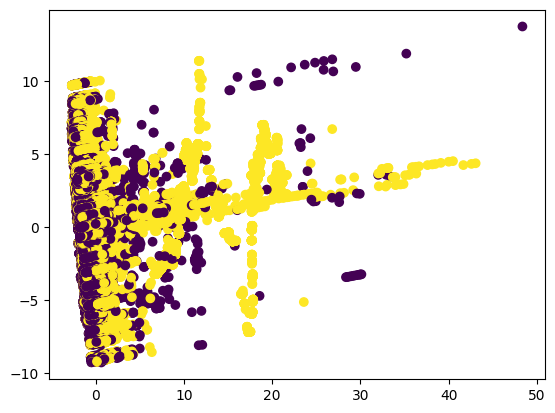

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
xpca = pca.fit_transform(optimus[numeric_var])
plt.scatter(x=xpca[:,0], y=xpca[:,1], c = y_t0.to_numpy())

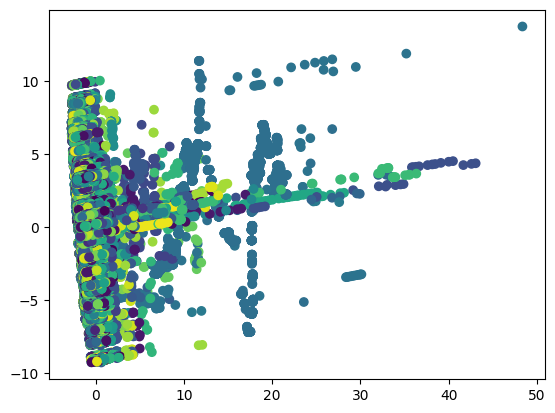

In [477]:
plt.scatter(x=xpca[:,0], y=xpca[:,1], c=X_t0['wallet_address_id'])

In [479]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
xtsne = tsne.fit_transform(optimus[numeric_var])

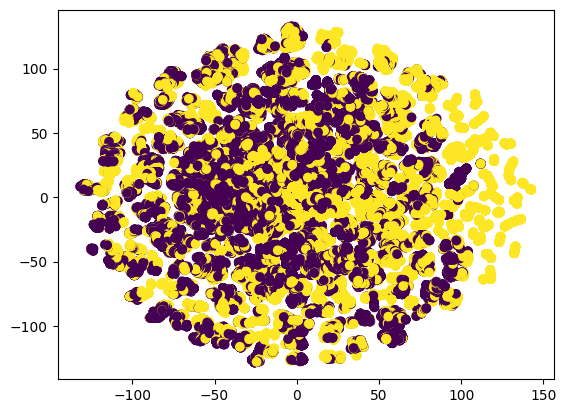

In [480]:
plt.scatter(x=xtsne[:,0], y=xtsne[:,1], c = y_t0.to_numpy())

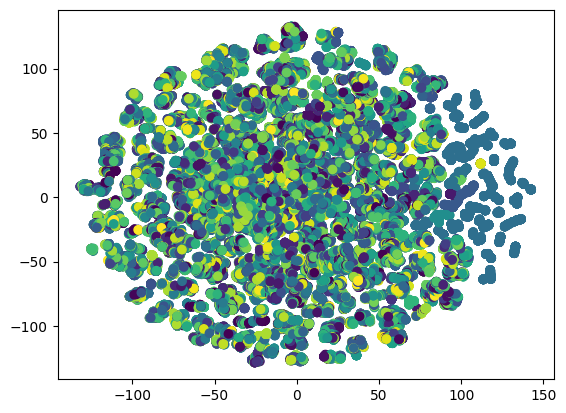

In [482]:
plt.scatter(x=xtsne[:,0], y=xtsne[:,1], c=X_t0['wallet_address_id'])

# División conjunto de datos

Dado que las clases están en proporciones relativamente similares, no consideramos necesario 

In [452]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(optimus, y_t0.values, 
                                                    test_size=0.3, random_state=29, shuffle=True,)

# Baseline

##### **2.3 Baseline [0.25 puntos]**

En esta sección se debe construir el modelo más sencillo posible que pueda resolver el problema planteado, conocido como **modelo baseline**. Su propósito es servir como referencia para comparar el rendimiento de los modelos más avanzados desarrollados en etapas posteriores.  

Pasos requeridos:  
- Implemente, entrene y evalúe un modelo básico utilizando un pipeline.  
- Asegúrese de incluir en el pipeline las transformaciones del preprocesamiento realizadas previamente junto con un clasificador básico.  
- Evalúe el modelo y presente el informe de métricas utilizando **`classification_report`**.  

Documente claramente cómo se creó el modelo, las decisiones tomadas y los resultados obtenidos. Este modelo será la base comparativa en las secciones posteriores.

---

In [453]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [454]:
# Aplico labelEncoder a la col 'wallet_address'

encoder = LabelEncoder()
encoder.fit(X_t0.wallet_address)

X_train.wallet_address  = encoder.transform(X_train.wallet_address)
X_test.wallet_address = encoder.transform(X_test.wallet_address)

In [455]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)

# dummy.score:Return the mean accuracy on the given test data and labels.
dummy_clf.score(X_test, y_test)

0.5107231544886749

In [456]:
lsvc = LinearSVC(random_state=29)
lsvc.fit(X_train.drop(columns=timestamps), y_train)
y_lsvc = lsvc.predict(X_test.drop(columns=timestamps))
lsvc.score(X_test.drop(columns=timestamps), y_test)

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7543833245541425

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



Text(0, 0.5, 'True positive rate')

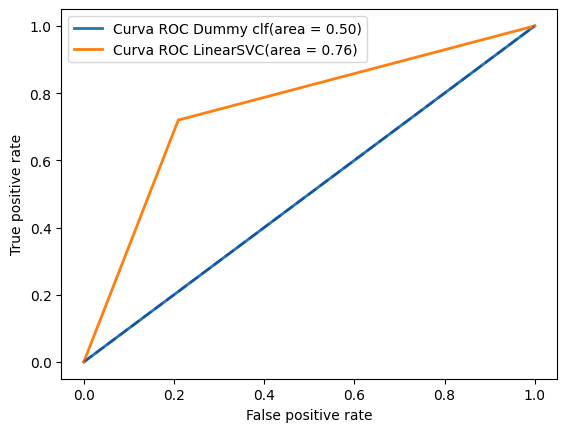

In [457]:
# AUC curve
models = ['Dummy clf', 'LinearSVC']

for i, y in enumerate([y_dummy, y_lsvc]):
    fpr, tpr, thresholds = roc_curve(y_test, y, pos_label=2)
    auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(y_test, y,)
    roc_auc = roc_auc_score(y_test, y)

    plt.plot(fpr, tpr, lw=2, label=f'Curva ROC {models[i]}(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.3)
plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [458]:
print(classification_report(y_test, y_dummy))
print(classification_report(y_test, y_lsvc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6502
           1       0.51      1.00      0.68      6787

    accuracy                           0.51     13289
   macro avg       0.26      0.50      0.34     13289
weighted avg       0.26      0.51      0.35     13289

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      6502
           1       0.78      0.72      0.75      6787

    accuracy                           0.75     13289
   macro avg       0.76      0.76      0.75     13289
weighted avg       0.76      0.75      0.75     13289



d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [459]:
lsvc.score(X_test.drop(columns=['wallet_address']), y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- borrow_timestamp
- risky_first_tx_timestamp
- risky_last_tx_timestamp
Feature names seen at fit time, yet now missing:
- wallet_address


The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is achieved by having few false negatives in the relevant results. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all relevant results (high recall).

In [ ]:
y_score = lsvc.decision_function(X_test.drop(columns=timestamps))

display = PrecisionRecallDisplay.from_predictions(
    y_lsvc, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# 3 modelos de ML (nuevos)


---

##### **2.4 Modelos de Machine Learning [0.5 puntos]**

Esta sección debe detallar la creación de tres modelos más avanzados. Cada modelo debe incluirse en un pipeline que combine el preprocesamiento de datos y un clasificador. A continuación, describa:  
- **Estructura y diferencias entre los modelos:** Explique los clasificadores seleccionados, sus hiperparámetros iniciales y el enfoque utilizado para cada uno.  
- **Resultados:** Evalúe cada modelo utilizando **`classification_report`**, destacando métricas clave como precisión, recall y F1-score.  
- **Clasificadores sugeridos:** Puede seleccionar entre los siguientes:  
  - `LogisticRegression`  
  - `KNeighborsClassifier`  
  - `DecisionTreeClassifier`  
  - `SVC`  
  - `RandomForestClassifier`  
  - `LightGBMClassifier` (del paquete `lightgbm`)  
  - `XGBClassifier` (del paquete `xgboost`)
  - Otro

Además, responda las siguientes preguntas para evaluar el rendimiento de los modelos:  
1. ¿Hay algún clasificador que supere al modelo baseline?  
2. ¿Cuál es el mejor clasificador entrenado y por qué?  
3. ¿Qué factores hacen que el mejor clasificador sea superior a los otros?  
4. En términos de tiempo de entrenamiento, ¿qué modelo considera más adecuado para experimentar con grillas de optimización?  

Finalmente, seleccione **uno de los tres modelos** desarrollados para continuar con las siguientes secciones. Justifique su elección basándose en criterios metodológicos y de rendimiento, explicando por qué este modelo es el más adecuado para abordar el problema planteado.  

Además, se recomienda realizar un análisis preliminar de interpretabilidad sobre su modelo baseline utilizando herramientas básicas. Esto le permitirá comprender de manera general cómo el modelo está tomando decisiones y podría ser de gran utilidad más adelante, cuando trabaje con su modelo final, para comparar y validar los resultados obtenidos.

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# y_true: valores reales
# y_scores: probabilidades predichas por el modelo
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
auc_pr = auc(recall, precision)

print("AUC-PR:", auc_pr)